# Import Library

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load data

In [2]:
data=pd.read_csv('data\mass_31012025.csv',comment='#', delim_whitespace=True)
data

,X_Value,Channel4,Channel3,Channel2,Channel1
0,0.000000e+00,-0.0072,-0.0008,-0.0040,0.0020
1,2.000000e-10,-0.0080,-0.0008,-0.0036,0.0020
2,4.000000e-10,-0.0088,-0.0008,-0.0032,0.0020
3,6.000000e-10,-0.0084,-0.0016,-0.0036,0.0020
4,8.000000e-10,-0.0076,-0.0012,-0.0036,0.0020
...,...,...,...,...,...
2540630,2.640247e+05,-0.0076,-0.0012,-0.0052,0.0024
2540631,2.640247e+05,-0.0080,-0.0012,-0.0044,0.0024
2540632,2.640247e+05,-0.0076,-0.0016,-0.0028,0.0040
2540633,2.640247e+05,-0.0080,-0.0012,-0.0028,0.0044


In [5]:
x=np.linspace(0,data['X_Value'].max(),len(data['X_Value']))
y=data['X_Value']
# plt.plot(x,y)

In [6]:
# Detect large jumps (discontinuities)
dy = np.abs(np.diff(y))  # Compute absolute differences
threshold = np.mean(dy) + 1 * np.std(dy)  # Adaptive threshold
discontinuity_indices = np.where(dy > threshold)[0]
#print(discontinuity_indices)

# Extract x-values where discontinuities occur
discontinuity_x = x[discontinuity_indices+1]  

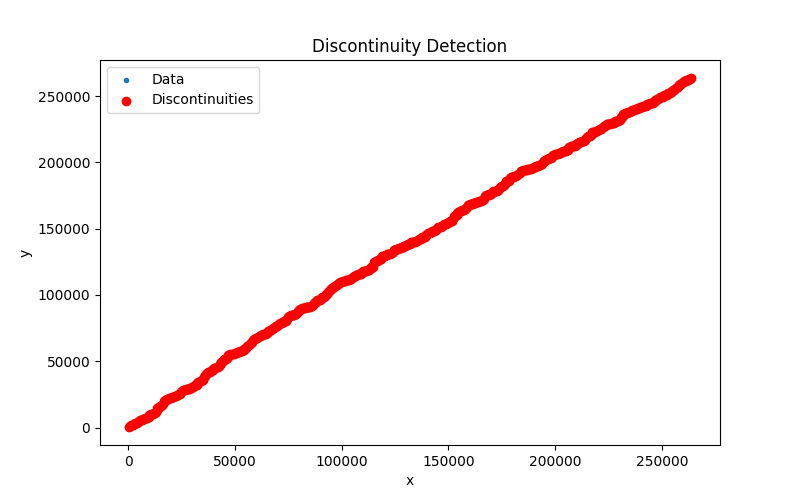

Number of discontinuity detected at x-values: 617


In [7]:
# Plotting
plt.figure(figsize=(8, 5))
plt.scatter(x, y, label='Data',marker='.')
plt.scatter(discontinuity_x, y[discontinuity_indices], color='red', label='Discontinuities', zorder=3)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Discontinuity Detection')
plt.show()

# Print detected discontinuities
print("Number of discontinuity detected at x-values:", len(discontinuity_x))

# Plot Events

In [8]:
event_labels = np.insert(discontinuity_indices+1,0,0)
len(event_labels), event_labels

(618,
 array([      0,    4001,    8002,   12003,   16004,   20005,   24006,
          28007,   32008,   36009,   40010,   44011,   48012,   52013,
          56014,   60015,   64016,   68017,   72018,   76019,   80020,
          84021,   88022,   92023,   96024,  100025,  104026,  108027,
         112028,  116029,  120030,  124031,  128032,  132033,  136034,
         140035,  144036,  148037,  152038,  156039,  160040,  164041,
         168042,  172043,  176044,  180045,  184046,  188047,  192048,
         196049,  200050,  204051,  212053,  216054,  220055,  224056,
         228057,  232058,  236059,  240060,  244061,  248062,  252063,
         256064,  260065,  264066,  268067,  272068,  276069,  280070,
         284071,  288072,  292073,  296074,  300075,  304076,  308077,
         312078,  316079,  320080,  324081,  328082,  332083,  336084,
         340085,  344086,  348087,  352088,  356089,  360090,  364091,
         368092,  372093,  376094,  380095,  384096,  388097,  392098,


In [26]:
times=data['X_Value'].iloc[event_labels[0]:event_labels[0+1]]
i=453

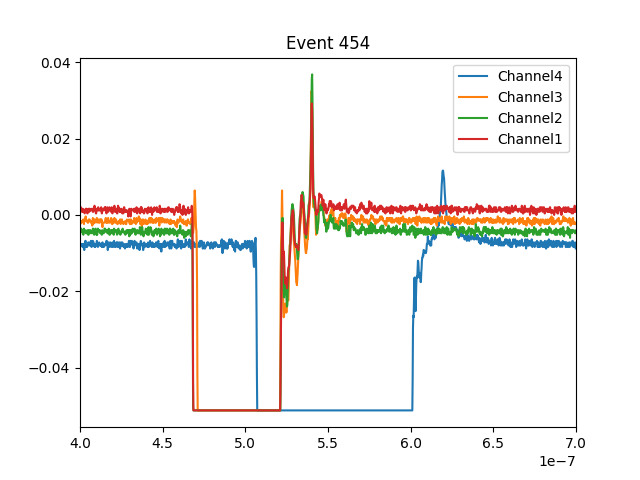

In [27]:
# for i in range(len(event_labels)):
plt.figure()
plt.title(f'Event {i+1}')
for column in data.columns[1:5]:
    if i == len(event_labels)-1:
        # print(data[column].iloc[event_labels[i]:])
        plt.plot(times,data[column].iloc[event_labels[i]:],label=column)
    else:
        # print(data[column].iloc[event_labels[i]:event_labels[i+1]])
        plt.plot(times,data[column].iloc[event_labels[i]:event_labels[i+1]],label=column)
plt.xlim((4e-7,7e-7))
plt.legend(loc='best')
plt.show()

# Another way to separate events

Stored in a list

Adding a column for `event_ID` and repeated the `X_Value` of the first event for all events

In [29]:
# Define event size
event_size = 4001

# Ensure the DataFrame can be evenly split
num_events = len(data) // event_size
print(f'Expected number of events: {num_events}')

# Assign an Event_ID column to the DataFrame
data = data.iloc[:num_events * event_size].copy()  # Trim excess rows if any
data['Event_ID'] = data.index // event_size

# Replace 'X_Value' for all events with 'times' from event 0
times = data[data['Event_ID'] == 0]['X_Value'].values
data['X_Value'] = np.tile(times, num_events)

#Store each event in the events list
events = []
for event_id in range(num_events):
    event_data = data[data['Event_ID'] == event_id]
    events.append(event_data)
# Optionally, store each event in separate CSV files    
    # event_data.to_csv(f"event_{event_id + 1}.csv", index=False)

# Print confirmation
print(f"Total events extracted: {len(events)}")

data

Expected number of events: 635
Total events extracted: 635


,X_Value,Channel4,Channel3,Channel2,Channel1,Event_ID
0,0.000000e+00,-0.0072,-0.0008,-0.0040,0.0020,0
1,2.000000e-10,-0.0080,-0.0008,-0.0036,0.0020,0
2,4.000000e-10,-0.0088,-0.0008,-0.0032,0.0020,0
3,6.000000e-10,-0.0084,-0.0016,-0.0036,0.0020,0
4,8.000000e-10,-0.0076,-0.0012,-0.0036,0.0020,0
...,...,...,...,...,...,...
2540630,7.992000e-07,-0.0076,-0.0012,-0.0052,0.0024,634
2540631,7.994000e-07,-0.0080,-0.0012,-0.0044,0.0024,634
2540632,7.996000e-07,-0.0076,-0.0016,-0.0028,0.0040,634
2540633,7.998000e-07,-0.0080,-0.0012,-0.0028,0.0044,634


In [52]:
by_event=data.groupby(data.Event_ID)

def plot_event(num_event, by_event=by_event):
    num_event=48
    event=(by_event.get_group(num_event)).drop(columns=['Event_ID'])
    event.plot(x='X_Value', y=['Channel4','Channel3','Channel2','Channel1'],
           xlim=(4e-7,7e-7), legend='True', #kind='scatter',
           title='Event '+str(num_event))

c:\Users\rsamu\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


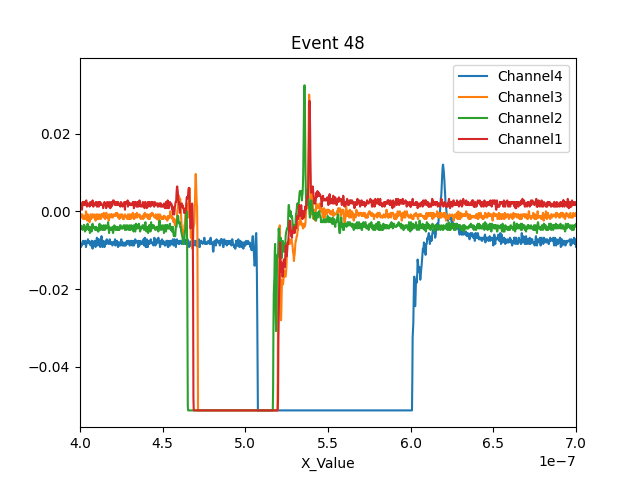

In [61]:
plot_event(495)

# Determination of the velocity 

In [55]:
#Constant experimentale
D12=64 #cm
D23=88 #cm
D13= 152 #cm

Ici j'essaie de choisir l'instant ti auquel le muon a été detecté la raquette i en essayant de calculer l'abscisse à laquelle on a une big discontinuité,histoire de recycler la tentative infractueuse du début du notebook.

In [80]:
def detect_discontinuity(y):
    # Detect large jumps (discontinuities)
    dy = np.abs(np.diff(y))  # Compute absolute differences
    print(np.mean(dy), np.std(dy))
    threshold = np.mean(dy) + 2 * np.std(dy)  # Adaptive threshold
    discontinuity_indices = np.where(dy > threshold)[0]
    #print(discontinuity_indices)

    # Extract x-values where discontinuities occur
    discontinuity_x = x[discontinuity_indices+1]  
    # print(discontinuity_x)
    
    return float(discontinuity_x), int(discontinuity_indices)

In [81]:
test_event_id = 495
test_event = (by_event.get_group(test_event_id)).drop(columns=['Event_ID'])
time_events = [detect_discontinuity(test_event.iloc[i]) for i in range(1,5)]

time_events


0.00500000005 0.0019899749395406985


TypeError: only size-1 arrays can be converted to Python scalars

L'idée c'était de plot l'abscisse à laquelle a lui la discontinuité. Mais j'en suis encore un peu loin. 

NameError: name 'dete' is not defined

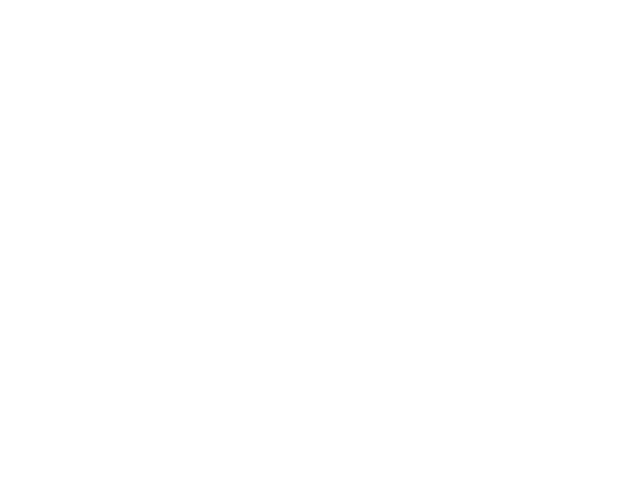

In [ ]:
plt.figure()
plt.scatter(dete, d, color='red', label='Discontinuities', zorder=3)
plot_event(test_event)

In [ ]:
columns = ['v12,v23,v13']
analysis=pd.DataFrame(

# Determination of the mass